Enter Stock Ticker (e.g. AMZN): AAPL


[*********************100%***********************]  1 of 1 completed


Enter the forecast horizon in trading days within the next year (1 - 252): 100


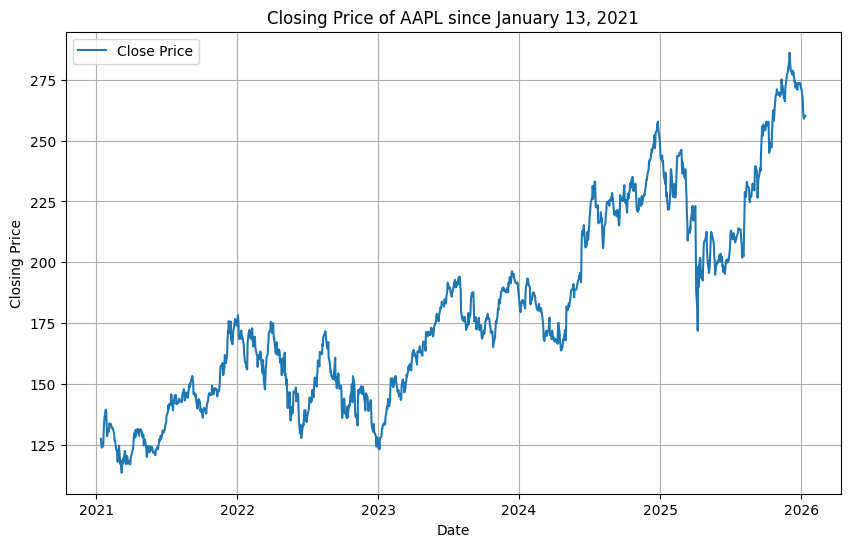

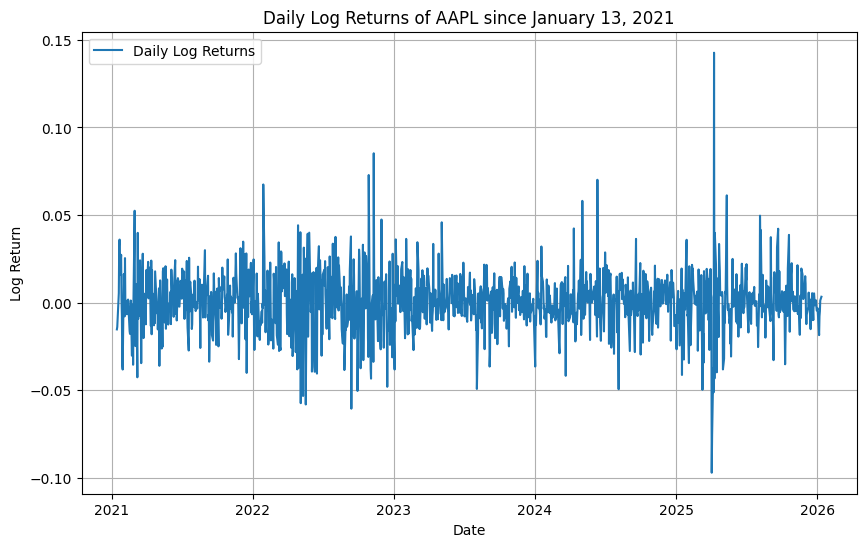

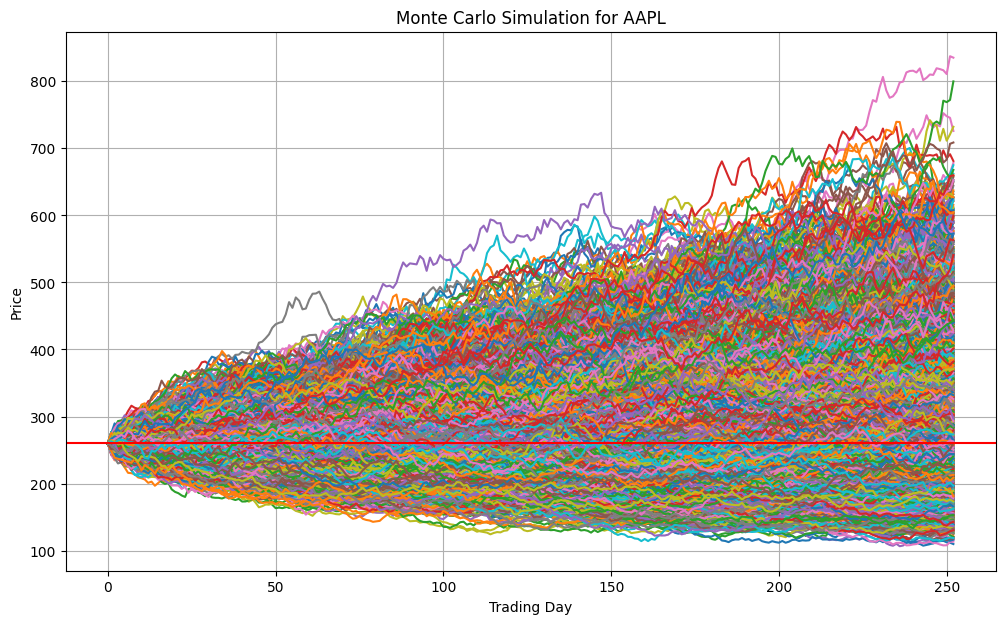


================= MONTE CARLO SIMULATIONS RESULTS FOR AAPL =================

--- Model Parameters ---
Number of Simulations: 10,000
Forecast Horizon: 252 trading days
Historical data of last 5 years from January 13, 2021 to January 13, 2026:
Annual Drift (μ): 14.35%
Annual Volatility (σ): 27.67%
Current Price on January 13, 2026: $260.25

--- Forecast Results in 100 Business Days ---
Expected Price: $271.41
Expected Return: +4.29%
25% Percentile: $241.03 (-7.38%)
75% Percentile: $305.15 (+17.25%)
90% Confidence Interval: ($203.35, $360.09)
Probability of Profit: 59.39%
Probability of >10% Gain: 37.74%
Probability of >10% Loss: 20.19%
Value at Risk (5% worst): $56.90 (21.86% loss)

--- Forecast Results in 252 Business Days (Last Simulated Day) ---
Expected Price: $289.80
Expected Return: +11.35%
25% Percentile: $239.54 (-7.96%)
75% Percentile: $347.45 (+33.51%)
90% Confidence Interval: ($182.92, $454.18)
Probability of Profit: 64.87%
Probability of >10% Gain: 51.65%
Probability of >10

In [11]:
!pip install numpy pandas yfinance matplotlib

import numpy as np
import pandas as pd
import yfinance as yf
import logging
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
logging.getLogger("yfinance").setLevel(logging.CRITICAL)

# set dynamic 5 year historical period
end_date = datetime.today()
start_date = end_date.replace(year = end_date.year - 5)
end_date_yf = end_date.strftime("%Y-%m-%d")
start_date_yf = start_date.strftime("%Y-%m-%d")
start_date = start_date.strftime("%B %d, %Y")
end_date = end_date.strftime("%B %d, %Y")


ticker_exist = False
# repeat prompt until ticker valid
while not ticker_exist:
  ticker = input("Enter Stock Ticker (e.g. AMZN): ").upper()
  try:
    # download Yahoo Finance stock data
    data = yf.download(ticker, start=start_date_yf, end=end_date_yf, auto_adjust = True)
    if(not data.empty):
      ticker_exist = True
    else:
      print("Invalid Ticker. Please Try Again")
  except Exception:
    print("Invalid Ticker. Please Try Again")

if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(1)


correct_time = False
# prompt user for dynamic forecast horizon
while not correct_time:
  simulated_day = input("Enter the forecast horizon in trading days within the next year (1 - 252): ")
  try:
    simulated_day = int(simulated_day)
    if(simulated_day >= 1 and simulated_day <= 252):
      correct_time = True
    else:
      print("Please enter a value between 1 and 252")
  except ValueError:
    print("Please enter a numeric value between 1 and 252")


# plot graph of closing prices
plt.figure(figsize=(10,6))
plt.plot(data["Close"], label = "Close Price")
plt.title(f"Closing Price of {ticker} since {start_date}")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.grid(True)
plt.show()


def calculate_return(data):
  # pct_change() = (Pt - Pt-1)/Pt-1 = (Pt/Pt-1) - 1
  # pct.change() + 1 to get daily return = (Pt/Pt-1)
  close_prices = data["Close"].squeeze()
  log_return = np.log(close_prices.pct_change() + 1)
  # remove first pct_change value of NaN, no previous day's price
  log_return = log_return[1:]
  return log_return


# plot daily log returns
log_return = calculate_return(data)
plt.figure(figsize = (10,6))
plt.plot(log_return, label = "Daily Log Returns")
plt.title(f"Daily Log Returns of {ticker} since {start_date}")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.show()

# annual drift
avg = log_return.mean() * 252
avg = avg.item()
# annual volatility
std = log_return.std() * np.sqrt(252)
std = std.item()
# 252 trading days in 1 year
num_days = 252
# num of simulated futures
num_simulations = 10000
last_price = data["Close"].iloc[-1]
last_price = last_price.item()


def monteCarlo(mean, std, num_days, num_simulations, last_price):
  # random shocks
  Z = np.random.normal(size = (num_days + 1, num_simulations))
  simulated = np.zeros((num_days + 1, num_simulations))
  simulated[0, :] = last_price
  for day in range(1, num_days + 1):
    # Geometric Brownian Motion formula
    simulated[day, :] = simulated[day-1, :] * np.exp((mean - 0.5*std**2)*(1/252) + std*(np.sqrt(1/252))*Z[day, :])
  return simulated

all_paths = monteCarlo(avg, std, num_days, num_simulations, last_price)


# plot Monte Carlo graph
graph = pd.DataFrame(all_paths)
graph.plot(legend = False, figsize=(12, 7))
plt.title(f"Monte Carlo Simulation for {ticker}")
plt.axhline(y = last_price, color = 'r', linestyle= '-')
plt.xlabel("Trading Day")
plt.ylabel("Price")
plt.grid(True)
plt.show()

# output variables
date_expected = np.median(all_paths[simulated_day, :])
date_return = (date_expected - last_price) / last_price
date_5 = np.percentile(all_paths[simulated_day, :], 5)
date_25 = np.percentile(all_paths[simulated_day, :], 25)
date_25_return = (date_25 - last_price) / last_price
date_75 = np.percentile(all_paths[simulated_day, :], 75)
date_75_return = (date_75 - last_price) / last_price
date_95 = np.percentile(all_paths[simulated_day, :], 95)
date_profit = np.sum(all_paths[simulated_day, :] > last_price)/num_simulations
date_ten_gain = np.sum(all_paths[simulated_day, :] > last_price * 1.1) / num_simulations
date_ten_loss = np.sum(all_paths[simulated_day, :] < last_price * 0.9) / num_simulations
var_5 = last_price - date_5

final_expected = np.median(all_paths[-1, :])
final_return = (final_expected - last_price) / last_price
final_5 = np.percentile(all_paths[-1, :], 5)
final_25 = np.percentile(all_paths[-1, :], 25)
final_25_return = (final_25 - last_price) / last_price
final_75 = np.percentile(all_paths[-1, :], 75)
final_75_return = (final_75 - last_price) / last_price
final_95 = np.percentile(all_paths[-1, :], 95)
final_profit = np.sum(all_paths[-1, :] > last_price)/num_simulations
final_ten_gain = np.sum(all_paths[-1, :] > last_price * 1.1) / num_simulations
final_ten_loss = np.sum(all_paths[-1, :] < last_price * 0.9) / num_simulations
final_var_5 = last_price - final_5




print(f"\n================= MONTE CARLO SIMULATIONS RESULTS FOR {ticker} =================")
print("\n--- Model Parameters ---")
print(f"Number of Simulations: {num_simulations:,}")
print(f"Forecast Horizon: {num_days} trading days")
print(f"Historical data of last 5 years from {start_date} to {end_date}:")
print(f"Annual Drift (μ): {avg:.2%}")
print(f"Annual Volatility (σ): {std:.2%}")
print(f"Current Price on {end_date}: ${last_price:.2f}")

print(f"\n--- Forecast Results in {simulated_day} Business Days ---")
print(f"Expected Price: ${date_expected:.2f}")
print(f"Expected Return: {date_return:+.2%}")
print(f"25% Percentile: ${date_25:.2f} ({date_25_return:+.2%})")
print(f"75% Percentile: ${date_75:.2f} ({date_75_return:+.2%})")
print(f"90% Confidence Interval: (${date_5:.2f}, ${date_95:.2f})")
print(f"Probability of Profit: {date_profit:.2%}")
print(f"Probability of >10% Gain: {date_ten_gain:.2%}")
print(f"Probability of >10% Loss: {date_ten_loss:.2%}")
print(f"Value at Risk (5% worst): ${var_5:.2f} ({var_5/last_price:.2%} loss)")

print(f"\n--- Forecast Results in 252 Business Days (Last Simulated Day) ---")
print(f"Expected Price: ${final_expected:.2f}")
print(f"Expected Return: {final_return:+.2%}")
print(f"25% Percentile: ${final_25:.2f} ({final_25_return:+.2%})")
print(f"75% Percentile: ${final_75:.2f} ({final_75_return:+.2%})")
print(f"90% Confidence Interval: (${final_5:.2f}, ${final_95:.2f})")
print(f"Probability of Profit: {final_profit:.2%}")
print(f"Probability of >10% Gain: {final_ten_gain:.2%}")
print(f"Probability of >10% Loss: {final_ten_loss:.2%}")
print(f"Value at Risk (5% worst): ${final_var_5:.2f} ({final_var_5/last_price:.2%} loss)")



